### Test 2: Machine learning

In this test we will use the entire dataset from the walmart kaggle challenge, do some feature engineering and data munging, then fit a random forest model to our data.

Again, the data is a csv file which contains one line for each scan on their system, with a Upc, Weekday, ScanCount, DepartmentDescription and FinelineNumber.

The VisitNumber column groups our data into baskets - Every unique VisitNumber is a unique basket, with a basket possibly containing multiple scans.

The label is the TripType column, which is Walmarts proprietary way of clustering their visits into categories. We wish to match their algorithm, and predict the category of some of our held out data.

This time we will use the full dataset - we have about 650,000 lines, in about 100,000 baskets. Just as a heads up, using 100 classifiers, my answer to the test takes less than 3 minutes to run - no need for hours and hours of computation.

If you do need to run this script multiple times, download the dataset from the website rather than redownloading each time, as it's around 30 mb.

Please answer the questions in the cells below them - feel free to answer out of order, but leave comments saying where you carried out the answer. I am working more or less step by step through my answer - Feel free to add on extra predictors if you can think of them.

1\. Import the modules you will use for the rest of the test:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

2\. Read in the data, and check its head. The data is available on the website at: http://jeremy.kiwi.nz/pythoncourse/assets/tests/test2data.csv

In [2]:
df = pd.read_csv('test2data.csv')

3\. Fix the Weekday and DepartmentDescription into dummified data. For now they can be seperate dataframes

In [3]:
weekdummies = pd.get_dummies(df.Weekday)
departdummies = pd.get_dummies(df.DepartmentDescription)

4\. Drop the unneeded columns from the raw data - I suggest removing - 'Weekday', 'Upc', 'DepartmentDescription' and 'FinelineNumber' (we could dummify Upc and FineLine, but this will massively increase our data size.)

In [4]:
df = df.drop(['Weekday','Upc','DepartmentDescription','FinelineNumber'],axis=1)

5\. Correct the Dummified data for number bought in each ScanCount. I would recommend something like:

`departdummies.multiply(dat['ScanCount'], axis = 0)`

In [5]:
departdummies = departdummies.multiply(df['ScanCount'], axis = 0)

6\. Concatenate back together the dummy variables with the main dataframe

In [6]:
df1 = pd.concat([df,departdummies,weekdummies],axis=1)
df1 = df1.drop(['ScanCount'],axis=1)

7\. Summarise the data for each basket (hint, if you groupby columns, an .agg() method will not apply to them)

In [7]:
df2 = df1.groupby(['TripType','VisitNumber']).agg('sum')
df2[weekdummies.columns] = np.where(df2[weekdummies.columns]>0,1,0)

8\. Use the reset_index() method to remove your groupings. As we did not cover multiple indices in the lesson, my answer was 

`dat1 = dat1.reset_index()`

In [8]:
df3 = df2.reset_index()

In [9]:
df3.head()

,TripType,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,3,106,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3,121,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,153,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,162,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3,164,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


9\. Split the data into training and testing sets: Use 0.25 of the data in the test set.

In [10]:
X = df3[weekdummies.columns.append(departdummies.columns).values]
y = df3['TripType'].values

X['basket_size'] = X[departdummies.columns].sum(1)
X['basket_diversity'] = (X[departdummies.columns]>0).sum(1)
X['negative_itmes'] =  (X[departdummies.columns]<0).sum(1).div((X[departdummies.columns]!=0).sum(1)+0.1,axis=0)
# concentrate on one items or not
X['basket_concentrate'] = (X[departdummies.columns]>0).std(1)/((X[departdummies.columns]>0).mean(1)+0.1)

X[departdummies.columns] = X[departdummies.columns].div(np.where(X['basket_size']==0,1,abs(X['basket_size'])),axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

C:\Users\wliu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
X.describe()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,basket_size,basket_diversity,negative_itmes,basket_concentrate
count,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,...,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000
mean,0.159228,0.125708,0.176683,0.178983,0.117514,0.120513,0.121370,0.002236,0.002197,0.012283,...,0.010820,0.002699,0.010208,0.000569,0.010302,0.006760,7.488085,3.267763,0.042388,1.235178
std,0.365891,0.331522,0.381402,0.383340,0.322033,0.325563,0.326559,0.046191,0.038506,0.104559,...,0.088762,0.046105,0.095629,0.038107,0.092056,0.084904,10.249561,2.920906,0.189140,0.359335
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-2.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-52.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.057207
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,1.315289
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,0.000000,1.491338
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.500000,1.000000,1.000000,1.000000,1.000000,311.000000,25.000000,0.990991,1.518024


10\. Plot the training data using matplotlib or seaborn. Choose at least 3 meaningful plots to present aspects of the data.

the distribution of day types for each visit types:

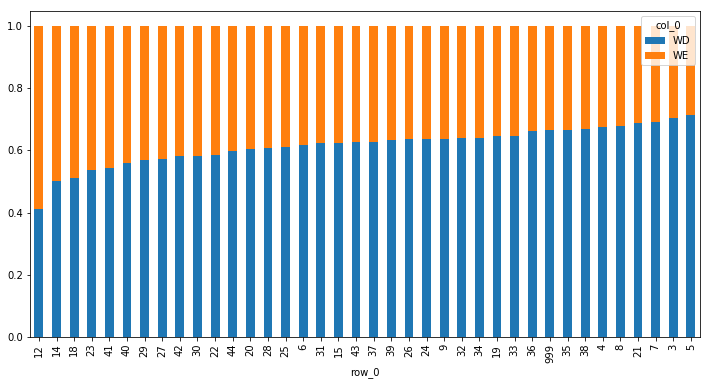

In [12]:
# for visit type 12, it is more likely on weekends than other types
# for visit type 5, it  is more likely on weekdays
weekdays = X_train[weekdummies.columns]

daytypes = np.where((weekdays.Saturday==1) |(weekdays.Sunday==1),'WE','WD' )

num_days_types = pd.crosstab(y_train,daytypes).T

pct_daytypes_visittypes=(num_days_types/num_days_types.sum(axis=0)).T.sort_values(['WD'])
pct_daytypes_visittypes.plot(kind='bar', stacked=True,figsize=(12,6))

the distribution of basket size for each visit types:

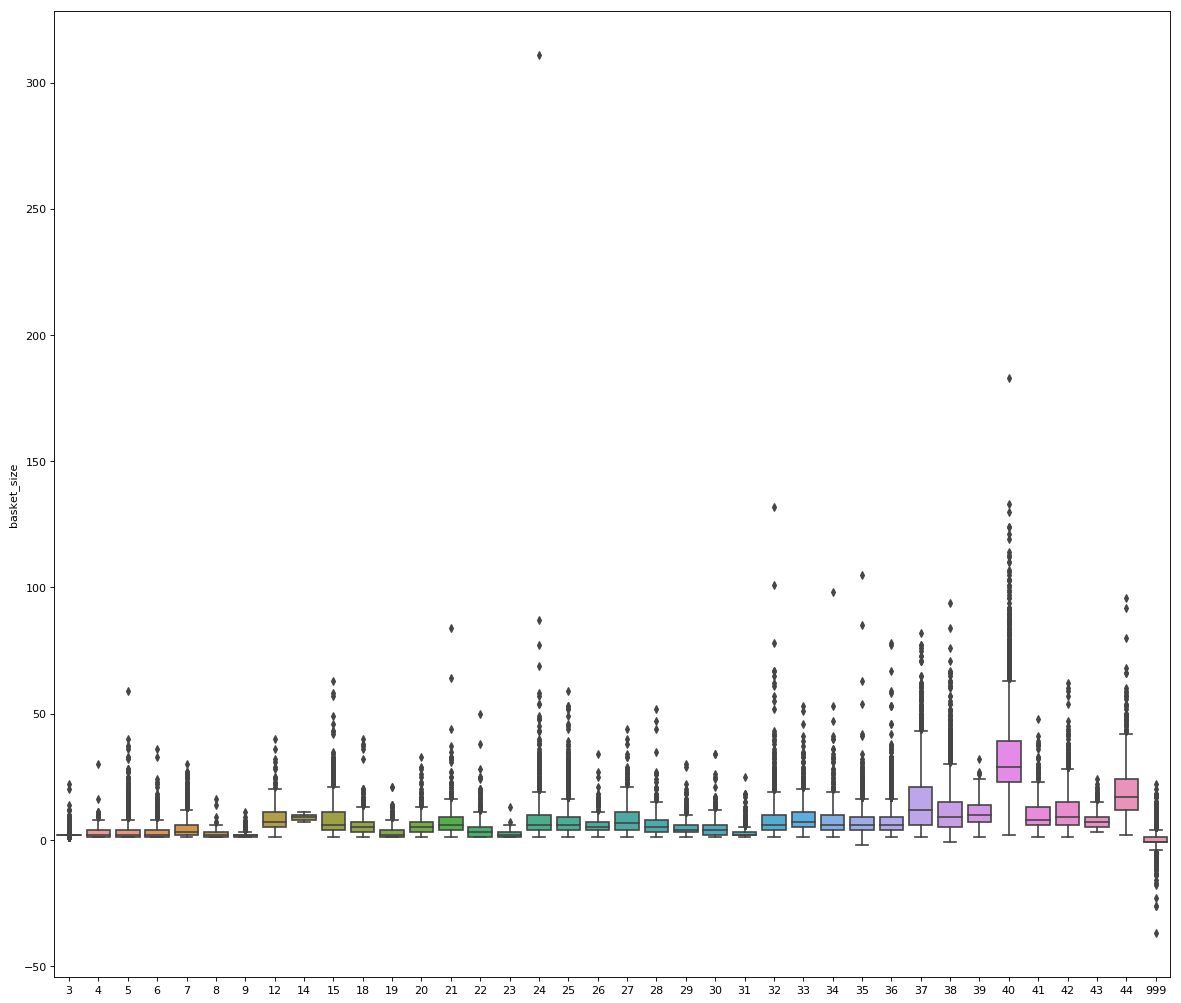

In [13]:
# visit type 40 & 44 have bigger basket size
# visit type 999 has negative basket, probably returning
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.boxplot(x=y_train,y='basket_size',data=X_train)

the distribution of basket diversity for each visit types:

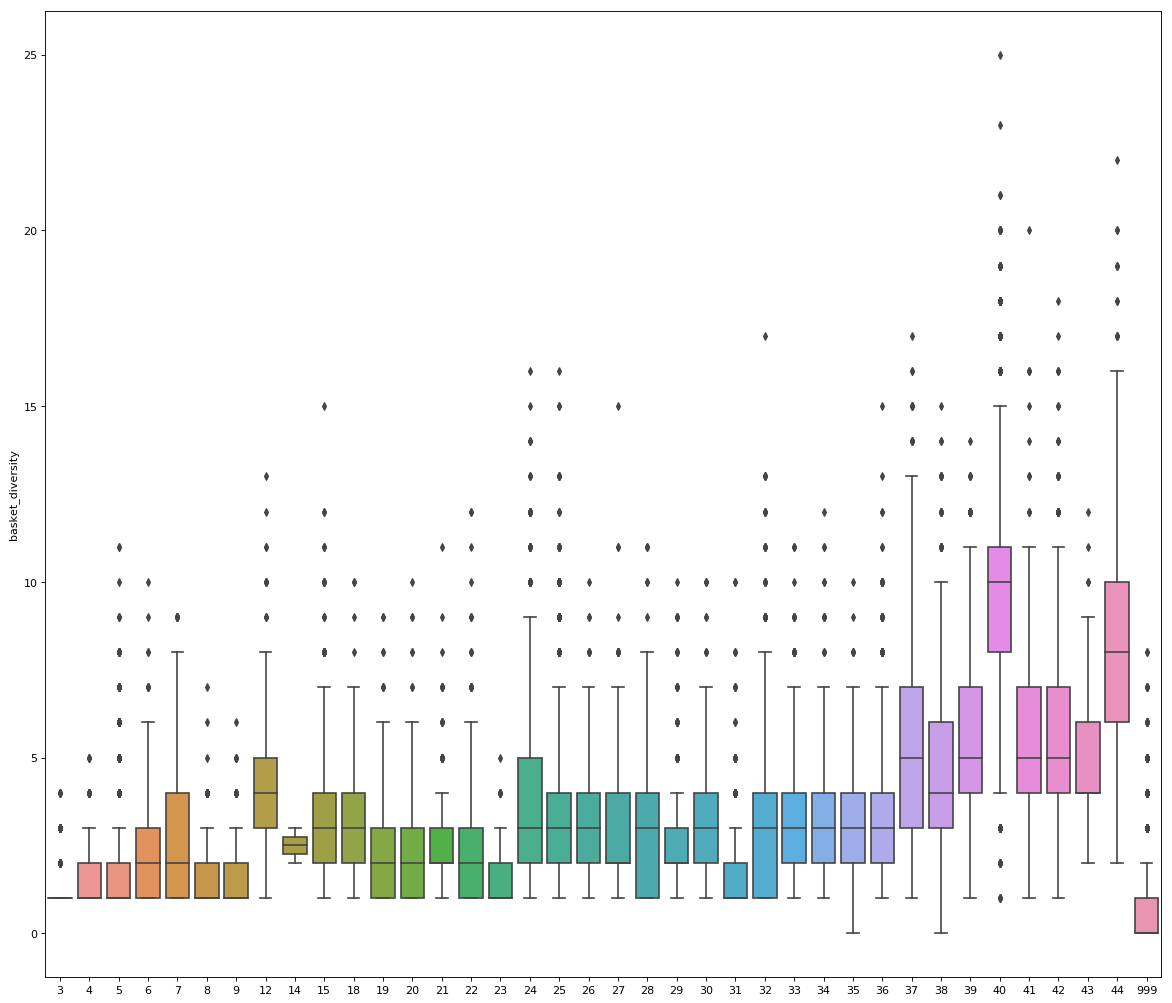

In [14]:
# 38 ~ 44 has much higher diversity
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.boxplot(x=y_train,y='basket_diversity',data=X_train)

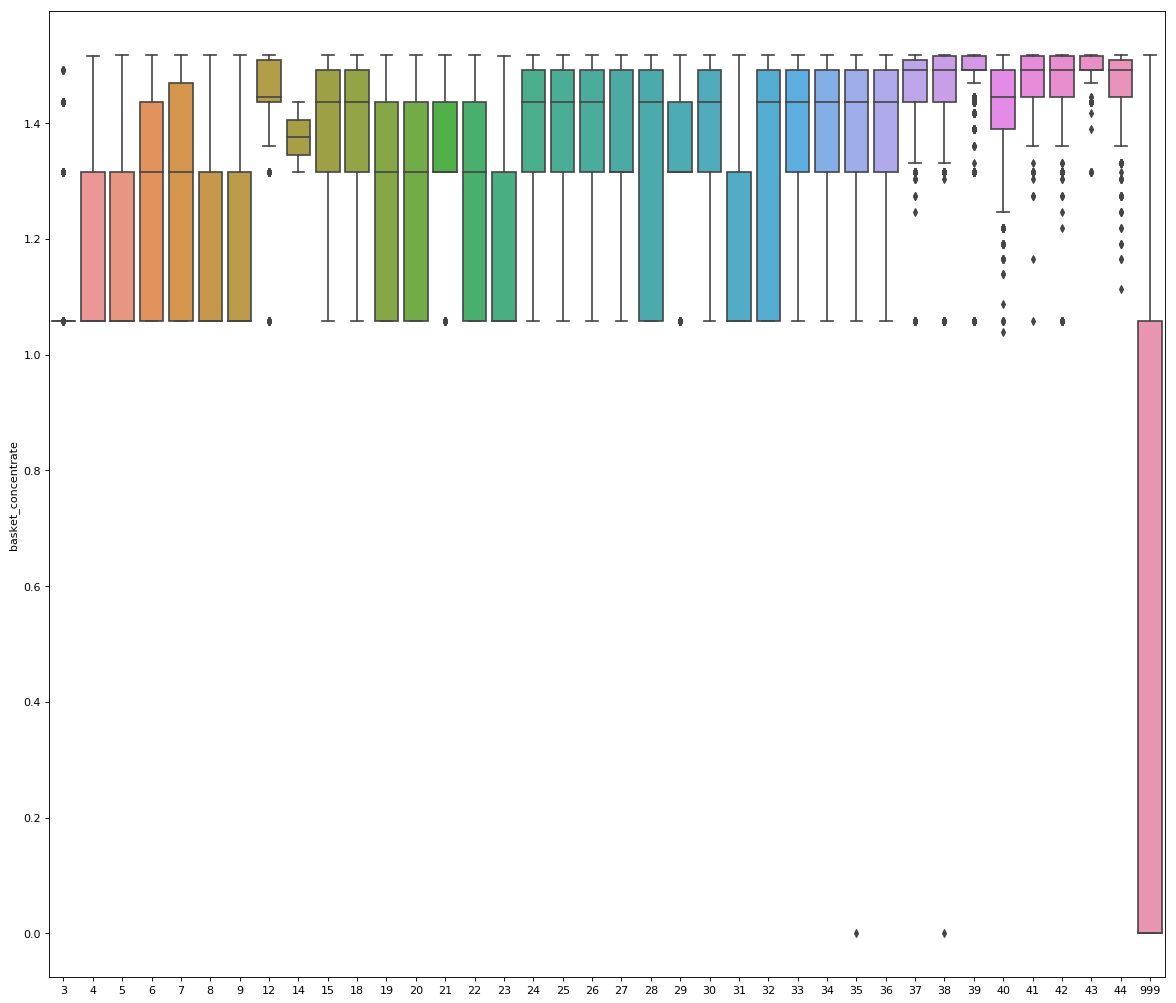

In [15]:
# some visit types concentrate on small portions like 3,4, 7, & 8
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.boxplot(x=y_train,y='basket_concentrate',data=X_train)

the distribution of department for each visit types:

In [16]:
# there are 66 departments, it's hard to show them on the chart
# so we using the kmeans to group those departmetns into 10
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler = StandardScaler()
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train[departdummies.columns])
kmeans_scaler = Pipeline([('scaler', scaler), ('kmeans', kmeans)])
kmeans_scaler.fit(X_train[departdummies.columns])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0))])

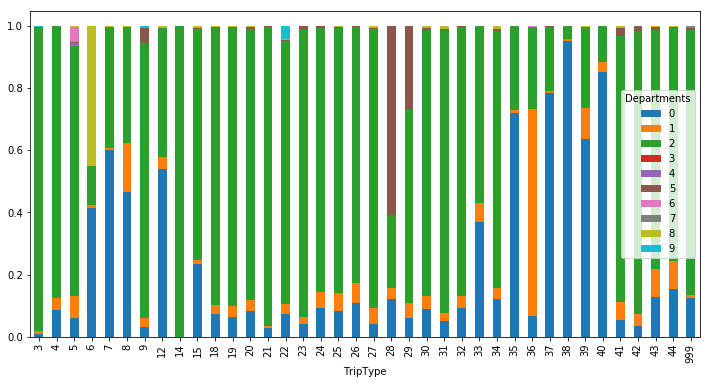

In [17]:
labels = kmeans_scaler.named_steps['kmeans'].labels_
basket_depart_visittype = pd.DataFrame(np.vstack([labels,y_train]).T,columns=['Departments','TripType'])
basket_depart_visittype = basket_depart_visittype.groupby(['TripType','Departments']).apply(len).reset_index()
basket_depart_visittype = basket_depart_visittype.pivot(index='TripType',columns='Departments',values=0).fillna(0)
pct_basket_depart_visittype = (basket_depart_visittype.T/basket_depart_visittype.T.sum(0)).T
pct_basket_depart_visittype.plot(kind='bar', stacked=True,figsize=(12,6))

11\. Take out the TripType from our dataframe - we don't want our label as a feature. 

Make sure to save it somewhere though, as our model needs to be fit to these labels.

11\. Describe and fit a randomForest Classifer with 100 `n_estimators`. 

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


param_grid = [
  {'max_depth': [10,15,20,30,40,50,55,60,65,70,80],'max_features':[5,15,20,25,30,40,50]}
 ]

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [10, 15, 20, 30, 40, 50, 55, 60, 65, 70, 80], 'max_features': [5, 15, 20, 25, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
clf.best_estimator_ 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

   mean_test_score param_max_depth param_max_features
0         0.531266              10                  5
1         0.583848              10                 15
2         0.579764              10                 20
3         0.577256              10                 25
4         0.571877              10                 30


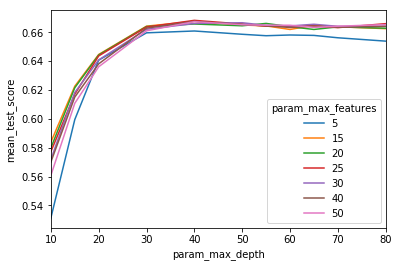

In [20]:
metrics = pd.DataFrame({x:y for x,y in clf.cv_results_.items() if x in ['mean_test_score','param_max_depth','param_max_features']})
print(metrics.head())
sns.tsplot(metrics, time='param_max_depth', unit = "param_max_features", 
               condition='param_max_features', value='mean_test_score')

In [21]:
maxfeatures = clf.best_estimator_.get_params()['max_features']
maxdepth = clf.best_estimator_.get_params()['max_depth']

param_grid = [
  {'min_samples_split': range(15,30,5)}
 ]

clf1 = GridSearchCV(RandomForestClassifier(max_features=maxfeatures,max_depth=maxdepth), param_grid, cv=5)
clf1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': range(15, 30, 5)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
clf1.best_estimator_


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=25,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

   mean_test_score param_min_samples_split
0         0.676678                      15
1         0.676343                      20
2         0.677653                      25


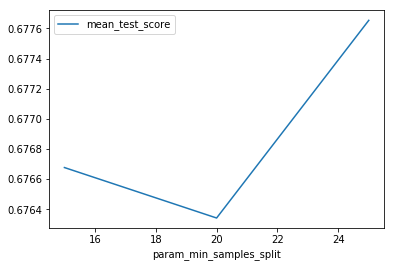

In [23]:
metrics1 = pd.DataFrame({x:y for x,y in clf1.cv_results_.items() if x in ['mean_test_score','param_min_samples_split']})
print(metrics1.head())
metrics1.plot(x='param_min_samples_split',y='mean_test_score')

In [24]:
minsamplessplit = clf.best_estimator_.get_params()['min_samples_split']
rf = RandomForestClassifier(max_depth=maxdepth,max_features=maxfeatures,min_samples_split=minsamplessplit,n_estimators = 100)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

13\. What is the score of the model on the training data?

In [25]:
rf.score(X_train,y_train)

0.9126193296634381

14\. What is the score of the model on the testing data?

In [26]:
rf.score(X_test,y_test)

0.6787491115849325

15\. What is the most important variable? Can you explain the model?

In [27]:
importance = pd.DataFrame({'columns':X.columns.values,'importance':rf.feature_importances_}).sort_values('importance',ascending=False)
importance.head(10)

,columns,importance
75,basket_size,0.150816
76,basket_diversity,0.051998
78,basket_concentrate,0.045281
27,FINANCIAL SERVICES,0.043928
24,DSD GROCERY,0.042303
64,PRODUCE,0.034056
57,PERSONAL CARE,0.033536
59,PHARMACY OTC,0.033511
31,GROCERY DRY GOODS,0.029136
23,DAIRY,0.028520


Thanks for taking the Python Course!

Please save your notebook file as 'your name - test2.ipynb', and email it to jeremycgray+pythoncourse@gmail.com by the 29th of April.